In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Latent Diffusion Training

In this notebook, we will train a simple `LatentDiffusion` model.

The training should take up to 20 hours for reasonable results.


In [2]:
import os, sys, argparse
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import seed_everything

import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio

from src import *

mpl.rcParams['figure.figsize'] = (8, 8)
sys.argv = ['ipykernel_launcher.py']

In [3]:
# Note: Actually it's totally unnecessay and silly to use argparse in jupyter notebook. 
# But anyway, it's a good chance to do some practice and it will definitey be useful someday.
parser = argparse.ArgumentParser()
parser.add_argument("--image_size", type=int, default=28, help="Image size")
parser.add_argument("--device", type=str, default=0 if torch.cuda.is_available() else "cpu", help="Device number.")
parser.add_argument("--num_workers", type=int, default=4, help="Spawn how many processes to load data.")
parser.add_argument("--seed", type=int, default=42, help='manual seed')
parser.add_argument("--max_epochs", type=int, default=1000, help="Max epoch number to run.")
parser.add_argument("--ckpt_path", type=str, default="", help="Checkpoint path to load.")
parser.add_argument("--save_path", type=str, default="./ckpt/", help="Checkpoint path to save.")
parser.add_argument("--save_freq", type=int, default=1, help="Save model every how many epochs.")
parser.add_argument("--ddim_steps", type=int, default=50, help="DDIM timesteps")
parser.add_argument("--lr", type=float, default=1e-4, help="Learning rate")
parser.add_argument("--batch_size", type=int, default=8, help="Batch size")


args = parser.parse_args()
seed_everything(args.seed)

Seed set to 42


42

In [4]:
# from datasets import load_dataset

# dataset = load_dataset("huggan/wikiart")

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/45 [00:00<?, ?it/s]

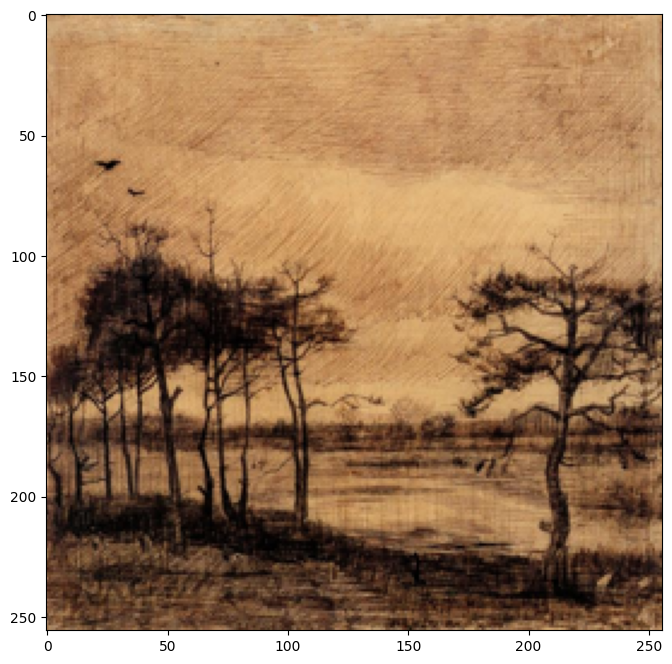

In [29]:
# print(dataset)

# train_dataset = dataset['train']
# new_dataset = train_dataset[:100]

# img_data = new_dataset['image']


# from PIL import Image
# import numpy as np

# target_size = (256, 256)  # 设定一个目标尺寸
# img_data_resized = [np.array(img.resize(target_size)) for img in img_data]

# # 现在你可以安全地将其转换为一个 NumPy 数组
# img_array = np.stack(img_data_resized)

# img_display = np.transpose(img_data_resized[0], (0, 1, 2))

# plt.imshow(img_display)
# plt.show()

def save_dataset(dataset, path):
    import pickle
    with open(path, 'wb') as f:
        pickle.dump(dataset, f)

# save_dataset(img_data_resized, 'test.pkl')

import pickle



train_data = pickle.load(open('test.pkl', 'rb'))

import matplotlib.pyplot as plt

plt.imshow(train_data[0])
plt.show()



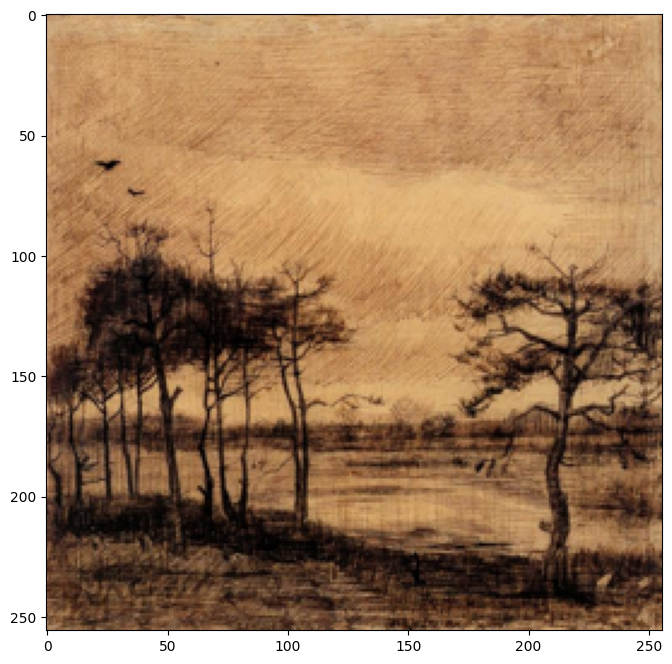

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# 由于 train_data 假设为 numpy 数组，我们需要先将其转换为 PIL 图像，然后应用转换
transform = transforms.Compose([
    transforms.ToPILImage(),          # 首先将 numpy 数组转换为 PIL 图像
    transforms.Resize((256, 256)),    # 确保图像是 256x256 大小
    transforms.ToTensor(),            # 将 PIL 图像转换为 Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 标准化
])

class WikiartDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img

# 假设 train_data 是一个100*256*256*3 的 NumPy 数组
wiki_dataset = WikiartDataset(train_data, transform=transform)

# 要显示图像，我们需要调整 tensor 的格式
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # 从 (C, H, W) 转换为 (H, W, C)
    img = 0.5 * img + 0.5  # 反标准化
    plt.imshow(img)
    plt.show()

# 获取数据集中的第一张图像并显示
imshow(wiki_dataset[0])

# 创建 DataLoader
dataloader = DataLoader(wiki_dataset, batch_size=8, shuffle=True, num_workers=4)


### Model Training

In [19]:
from src import *

# TODO begin: complete the LatentDiffusion Model in `src`
model = LatentDiffusion(lr=args.lr, batch_size=args.batch_size)
# TODO end

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/home/yitian/anaconda3/envs/diff/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Is Time embed used ?  True


...but first, let's check if the used `AutoEncoder` (`model.vae`) can reconstruct our samples well.

**You should always test your autoencoder in this way when using latent diffusion models on a new dataset.**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


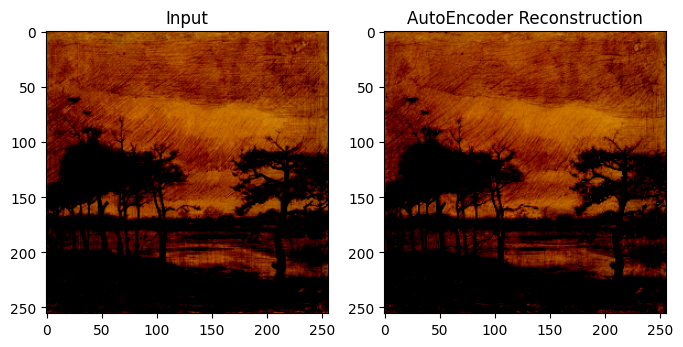

In [36]:
import torch
import matplotlib.pyplot as plt

# 获取数据集中的一张图像
img = wiki_dataset[0]

# 图像显示需要将通道从前移至后
img_to_show = img.permute(1, 2, 0)

plt.subplot(1, 2, 1)
plt.imshow(img_to_show, cmap='gray')
plt.title('Input')

# 使用模型进行重建
# 确保img是四维的：(1, Channels, Height, Width)
reconstructed_img = model.vae(img.unsqueeze(0))[0]

# 处理重建图像的维度，以便显示
reconstructed_img_to_show = reconstructed_img.permute(1, 2, 0).detach()

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img_to_show, cmap='gray')
plt.title('AutoEncoder Reconstruction')
plt.show()


In [ ]:
# Define the trainer using PyTorch Lightning
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(dirpath=args.save_path, every_n_epochs=args.save_freq)

# TODO: You can specify other parameters here, like accelerator, devices...
# You can check the pl.Trainer API here: https://lightning.ai/docs/pytorch/stable/common/trainer.html
trainer = pl.Trainer(
    max_epochs = args.max_epochs,
    callbacks = [EMA(0.9999), checkpoint_callback]
)

In [ ]:
# Easy to train the model in PyTorch Lightning in one line
trainer.fit(model, train_dataloaders=train_dataloader, ckpt_path=args.ckpt_path if args.ckpt_path else None)
# TODO: Can you add some logging and visualization codes to better babysitting the training process? 
# Hint: There are many librarys you can use, e.g. logging, tensorboard, wandb... And the easiest way: print the loss every step.

Go to sleep now ~ This one line might run for days...

Wait! Please make sure that you have save the checkpoints correctly.

If the code breaks for some reason, you can load the checkpoint and continue training.

### Now sample images from your model!

In [ ]:
model.to(args.device)
out = model(batch_size = args.batch_size, shape = (64,64), verbose = True)
# You can also try `sampler=DDIM_Sampler(num_steps=args.ddim_steps)`, which can sample images in less than 50 steps.

In [ ]:
for idx in range(out.shape[0]):
    plt.subplot(1, len(out), idx+1)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')